# Analysis Q-Wave Algorithms

## Setup and Helper Functions

In [2]:
import re
import json

from pathlib import Path

import pandas as pd
import numpy as np
import pingouin as pg

from fau_colors import cmaps, register_fausans_font

import biopsykit as bp
from biopsykit.stats import StatsPipeline

import matplotlib.pyplot as plt
import seaborn as sns

from pepbench.io import load_challenge_results_from_folder
from pepbench.datasets import EmpkinsDataset
from pepbench.data_handling import get_reference_pep, compute_pep_performance_metrics
from pepbench.data_handling.utils import reindex_empkins, reindex_guardian, rename_empkins, rename_guardian
from pepbench.plotting.results import (
    boxplot_reference_pep,
    vioplot_reference_pep,
    boxplot_algorithm_performance,
    violinplot_algorithm_performance,
    residual_plot_pep,
    residual_plot_pep_subject,
    residual_plot_pep_phase,
    residual_plot_pep_heart_rate,
    regplot_error_heart_rate,
    regplot_pep_heart_rate
)

%matplotlib widget
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
register_fausans_font()
plt.close("all")

palette = sns.color_palette(cmaps.faculties_light)
sns.set_theme(context="notebook", style="ticks", font="sans-serif", palette=palette)

plt.rcParams["figure.figsize"] = (10, 5)
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["mathtext.default"] = "regular"
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "FAUSans Office"

palette

[(0.37254901960784315, 0.48627450980392156, 0.6392156862745098),
 (0.6666666666666666, 0.7647058823529411, 0.8196078431372549),
 (1.0, 0.8235294117647058, 0.44313725490196076),
 (0.37254901960784315, 0.7725490196078432, 0.9254901960784314),
 (0.5372549019607843, 0.803921568627451, 0.4745098039215686),
 (0.8627450980392157, 0.4117647058823529, 0.48627450980392156)]

In [4]:
root_path = Path("../../")

In [5]:
deploy_type = "local"

config_dict = json.load(root_path.joinpath("config.json").open(encoding="utf-8"))

empkins_base_path = Path(config_dict[deploy_type]["empkins_path"])
guardian_base_path = Path(config_dict[deploy_type]["guardian_path"])
print(empkins_base_path)

/Users/richer/Documents/PhD/Projects/EmpkinS/HealthPsychology_D03/Data/2024_08_PEP_Benchmarking/EmpkinS_Dataset


In [6]:
result_path = root_path.joinpath("results")

In [7]:
dataset_empkins = EmpkinsDataset(empkins_base_path, use_cache=True, only_labeled=True)
dataset_empkins

EmpkinsDataset [150 groups/rows]

       participant condition    phase
   0        VP_001      tsst     Prep
   1        VP_001      tsst  Pause_1
   2        VP_001      tsst     Talk
   3        VP_001      tsst     Math
   4        VP_001      tsst  Pause_5
   ..          ...       ...      ...
   145      VP_032     ftsst     Prep
   146      VP_032     ftsst  Pause_1
   147      VP_032     ftsst     Talk
   148      VP_032     ftsst     Math
   149      VP_032     ftsst  Pause_5
   
   [150 rows x 3 columns]

In [8]:
algo_levels = ["q_wave_algorithm", "b_point_algorithm", "outlier_correction_algorithm"]
algo_level_mapping = dict(zip(algo_levels, ["Q-Wave Algorithm", "B-Point Algorithm", "Outlier Correction"]))

In [9]:
results_empkins = load_challenge_results_from_folder(
    result_path.joinpath("empkins_dataset_reference_b_point"), index_cols_per_sample=["participant", "condition", "phase"]
)

In [ ]:
results_guardian = load_challenge_results_from_folder(
    result_path.joinpath("guardian_dataset_reference_b_point"), index_cols_per_sample=["participant", "phase"]
)

In [10]:
metrics_empkins = compute_pep_performance_metrics(results_empkins.per_sample, num_heartbeats=results_empkins.agg_total)
metrics_empkins

Mean Absolute Error [ms]  \
                                                                                     mean   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm                            
dwt-neurokit      b-point-reference none                                         5.285479   
r-peak-diff-34-ms b-point-reference none                                         5.604800   
r-peak-diff-32-ms b-point-reference none                                         5.693200   
r-peak-diff-36-ms b-point-reference none                                         6.040800   
r-peak-diff-38-ms b-point-reference none                                         7.198800   
r-peak-diff-40-ms b-point-reference none                                         8.757200   
r-peak-diff-42-ms b-point-reference none                                        10.568400   

                                                                            \
                                                                       std   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm             
dwt-neurokit      b-point-reference none                          9.539331   
r-peak-diff-34-ms b-point-reference none                          4.384753   
r-peak-diff-32-ms b-point-reference none                          3.544741   
r-peak-diff-36-ms b-point-reference none                          5.273623   
r-peak-diff-38-ms b-point-reference none                          5.843091   
r-peak-diff-40-ms b-point-reference none                          6.240003   
r-peak-diff-42-ms b-point-reference none                          6.449530   

                                                                 Mean Error [ms]  \
                                                                            mean   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm                   
dwt-neurokit      b-point-reference none                               -4.415036   
r-peak-diff-34-ms b-point-reference none                               -2.415200   
r-peak-diff-32-ms b-point-reference none                               -0.415200   
r-peak-diff-36-ms b-point-reference none                               -4.415200   
r-peak-diff-38-ms b-point-reference none                               -6.415200   
r-peak-diff-40-ms b-point-reference none                               -8.415200   
r-peak-diff-42-ms b-point-reference none                              -10.415200   

                                                                            \
                                                                       std   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm             
dwt-neurokit      b-point-reference none                          9.972177   
r-peak-diff-34-ms b-point-reference none                          6.694159   
r-peak-diff-32-ms b-point-reference none                          6.694159   
r-peak-diff-36-ms b-point-reference none                          6.694159   
r-peak-diff-38-ms b-point-reference none                          6.694159   
r-peak-diff-40-ms b-point-reference none                          6.694159   
r-peak-diff-42-ms b-point-reference none                          6.694159   

                                                                 Mean Relative Error [%]  \
                                                                                    mean   
q_wave_algorithm  b_point_algorithm outlier_correction_algorithm                           
dwt-neurokit      b-point-reference none                                        6.759221   
r-peak-diff-34-ms b-point-reference none                                        7.363556   
r-peak-diff-32-ms b-point-reference none                                        7.253564   
r-peak-diff-36-ms b-point-reference none                                        8.088360   
r-peak-diff-38-ms b-point-reference none                                        9.62958

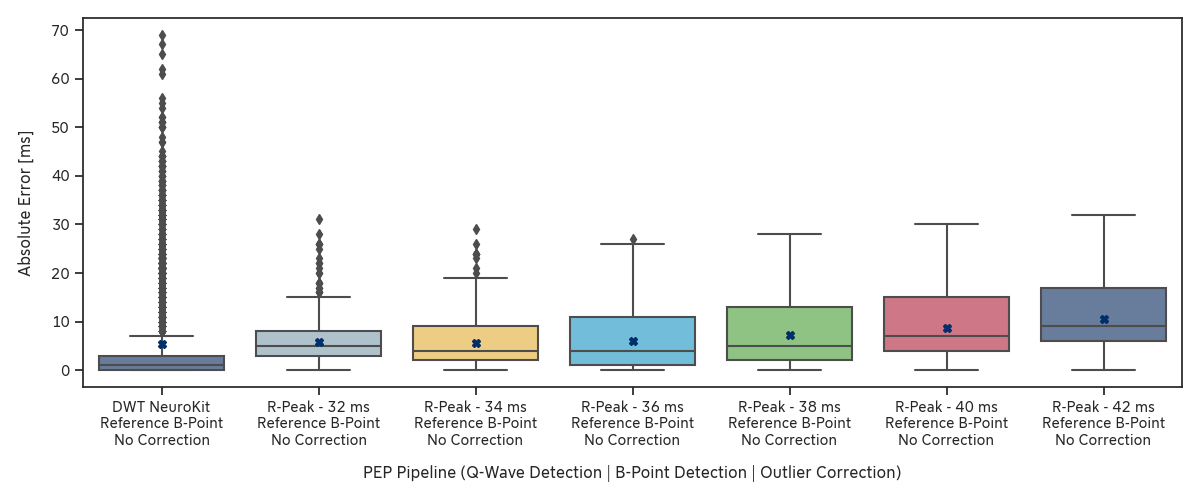

In [42]:
fig, ax = boxplot_algorithm_performance(
    results_empkins.per_sample, 
    metric="absolute_error_per_sample_ms", 
    showmeans=True,
    palette=cmaps.faculties_light,
    figsize=(12,5)
)

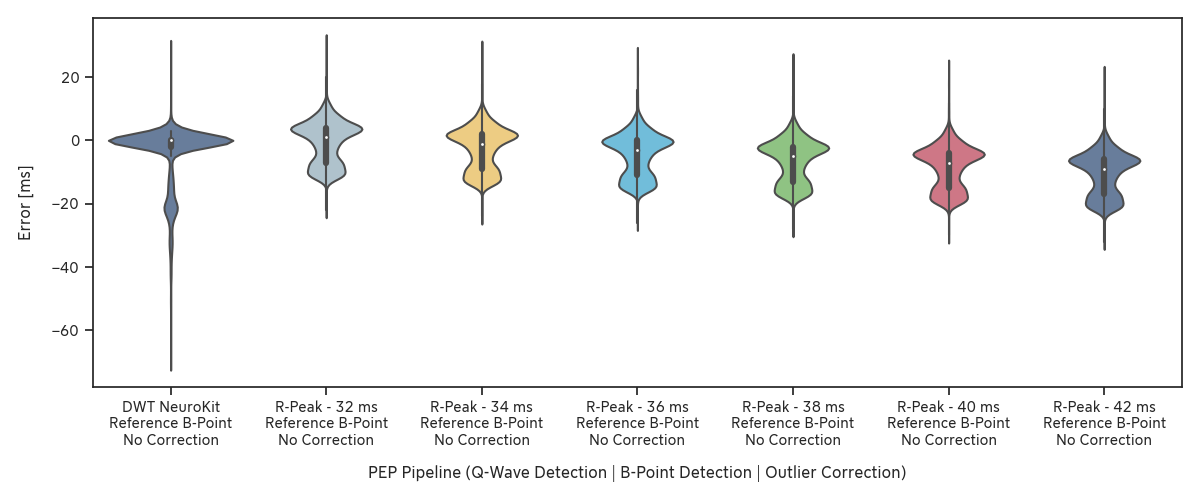

In [13]:
fig, ax = violinplot_algorithm_performance(
    results_empkins.per_sample, 
    metric="error_per_sample_ms", 
    showmeans=True,
    palette=cmaps.faculties_light,
    figsize=(12,5)
)

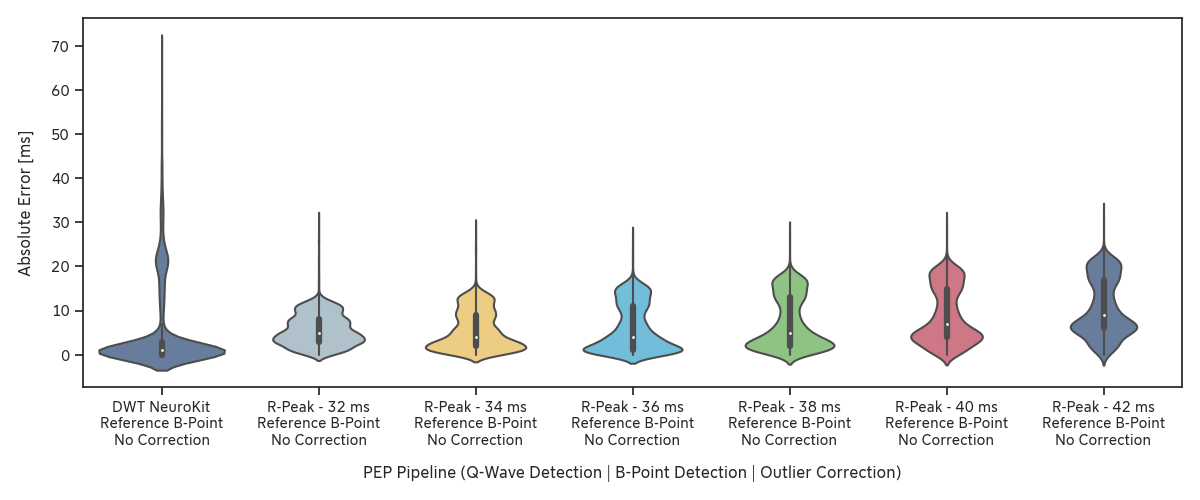

In [14]:
fig, ax = violinplot_algorithm_performance(
    results_empkins.per_sample, 
    metric="absolute_error_per_sample_ms", 
    showmeans=True,
    palette=cmaps.faculties_light,
    figsize=(12,5)
)

In [15]:
algo_combination = ("dwt-neurokit", "b-point-reference", "none")
algo_combination_2 = ("r-peak-diff-32-ms", "b-point-reference", "none")

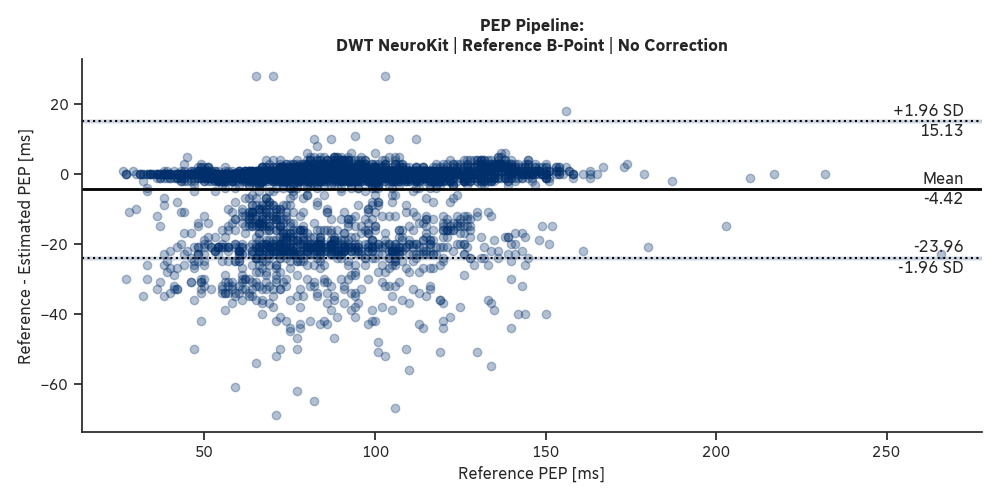

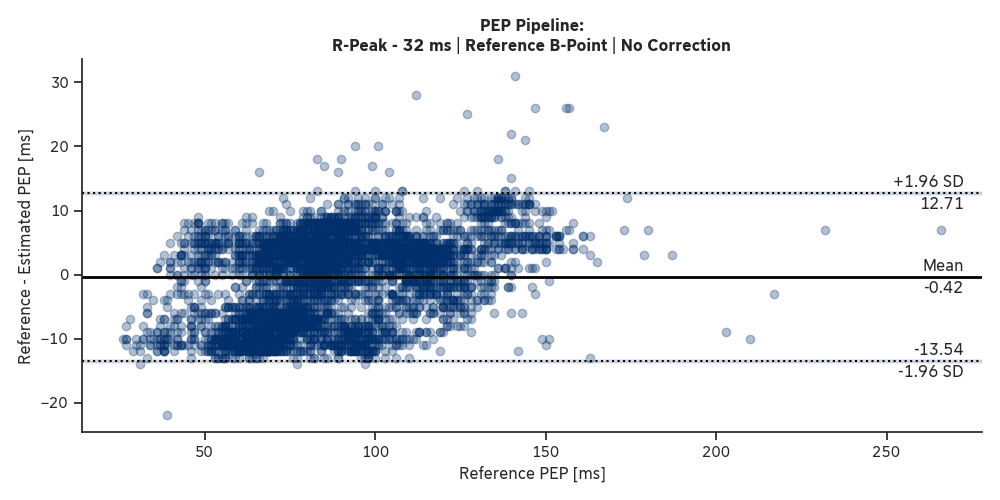

In [35]:
fig, ax = residual_plot_pep(results_empkins.per_sample, algo_combination)
fig, ax = residual_plot_pep(results_empkins.per_sample, algo_combination_2)

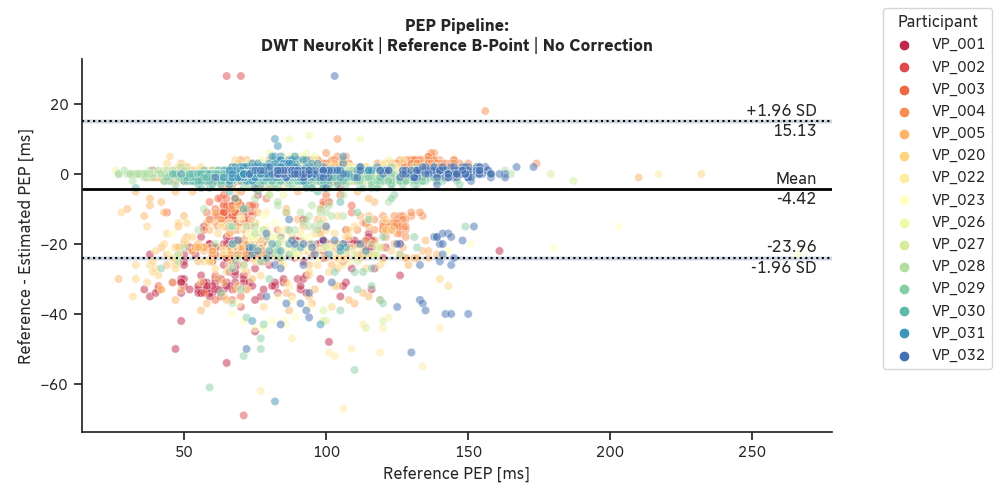

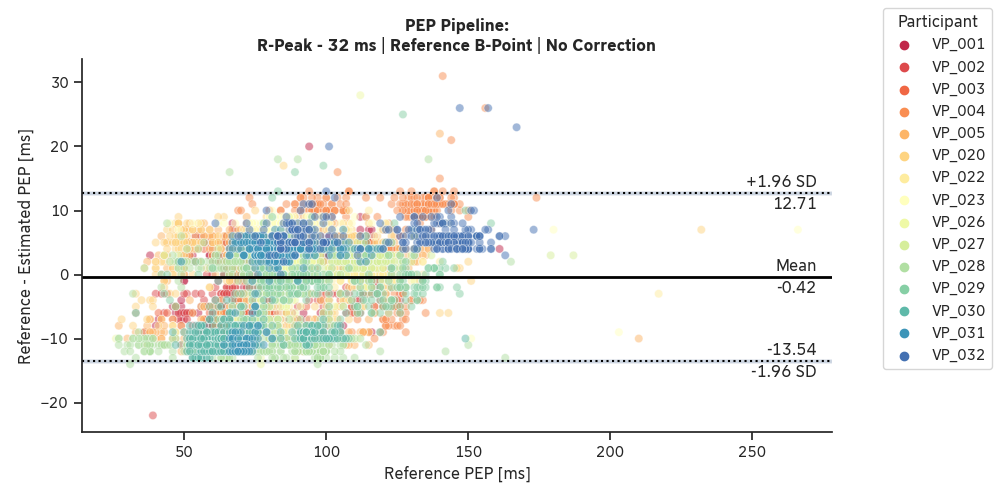

In [17]:
fig, ax = residual_plot_pep_subject(results_empkins.per_sample, algo_combination, alpha=0.5)
fig, ax = residual_plot_pep_subject(results_empkins.per_sample, algo_combination_2, alpha=0.5)

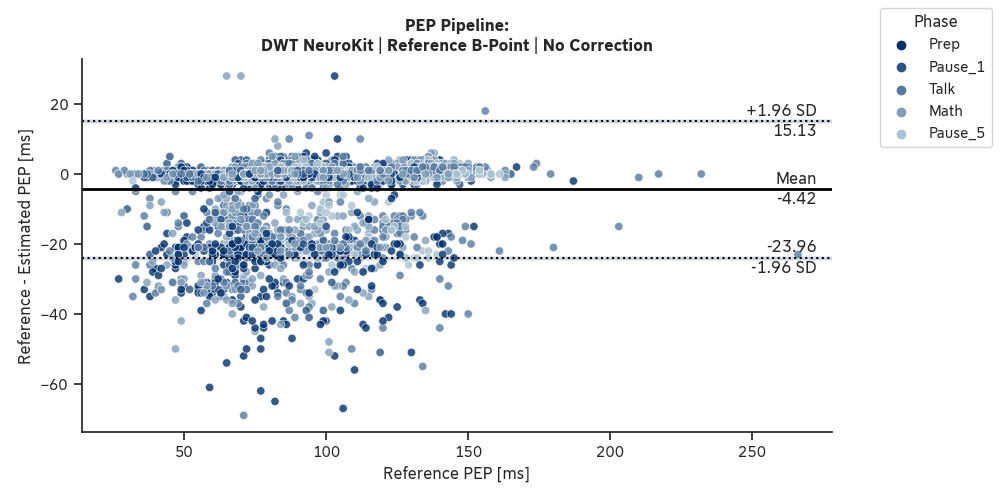

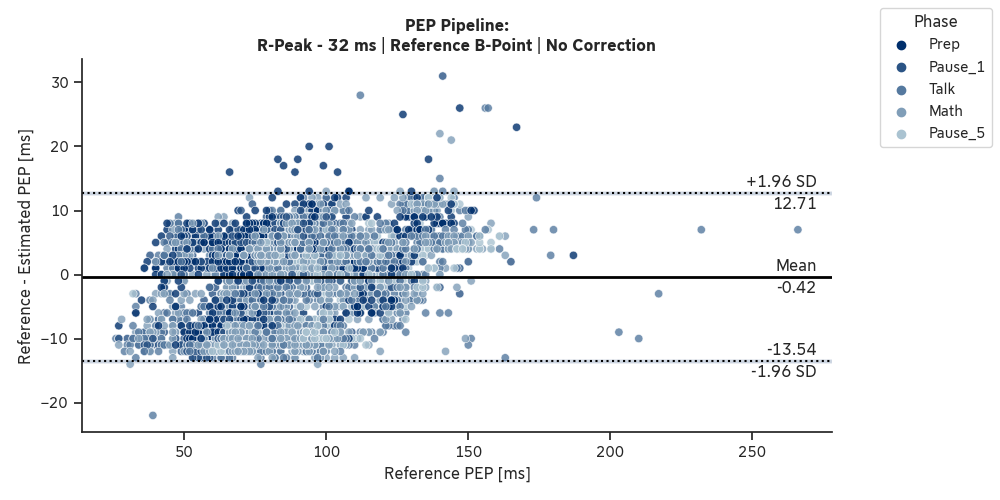

In [18]:
fig, ax = residual_plot_pep_phase(results_empkins.per_sample, algo_combination)
fig, ax = residual_plot_pep_phase(results_empkins.per_sample, algo_combination_2)

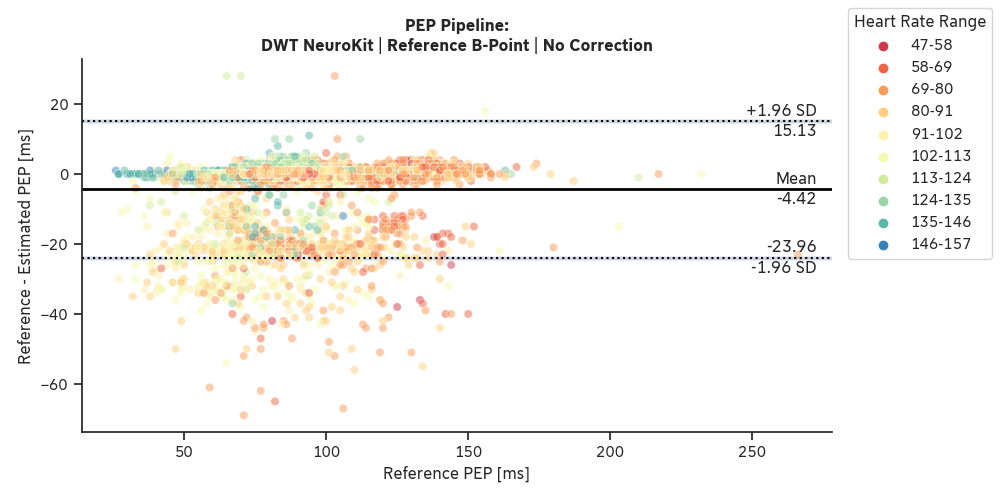

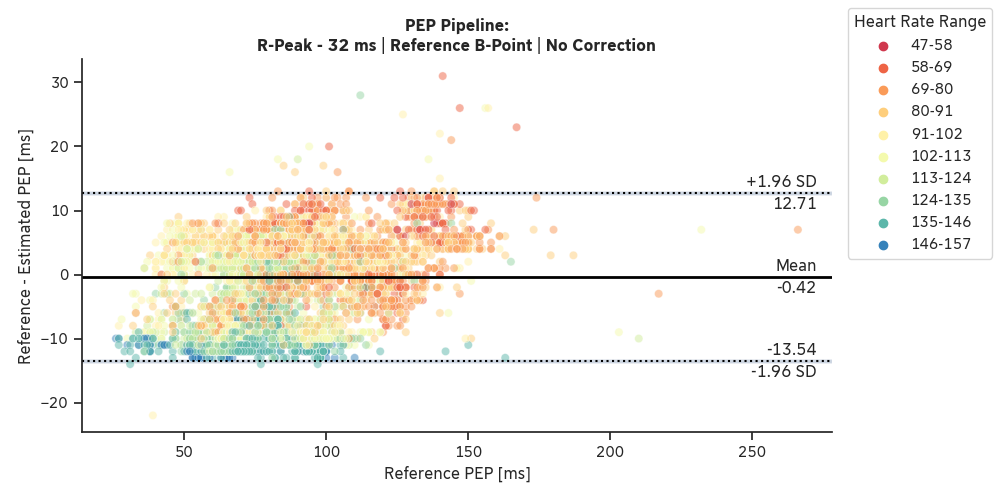

In [19]:
fig, ax = residual_plot_pep_heart_rate(results_empkins.per_sample, algo_combination, alpha=0.5)
fig, ax = residual_plot_pep_heart_rate(results_empkins.per_sample, algo_combination_2, alpha=0.5)

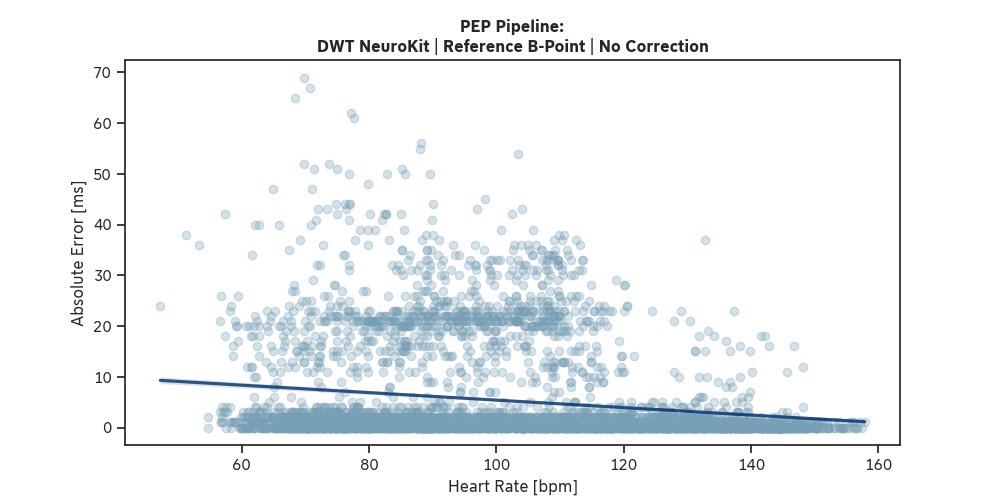

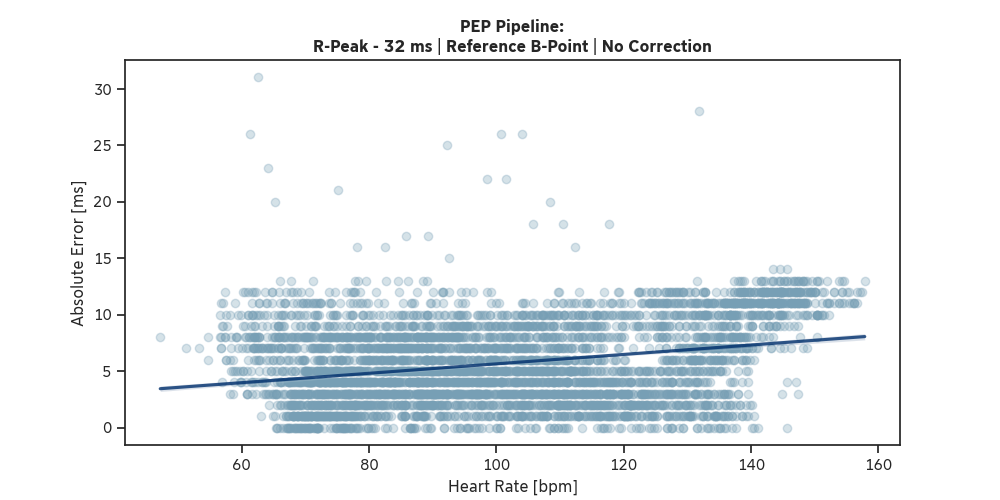

In [41]:
fig, ax = regplot_error_heart_rate(results_empkins.per_sample, algo_combination, error_metric="absolute_error_per_sample_ms")
fig, ax = regplot_error_heart_rate(results_empkins.per_sample, algo_combination_2, error_metric="absolute_error_per_sample_ms")

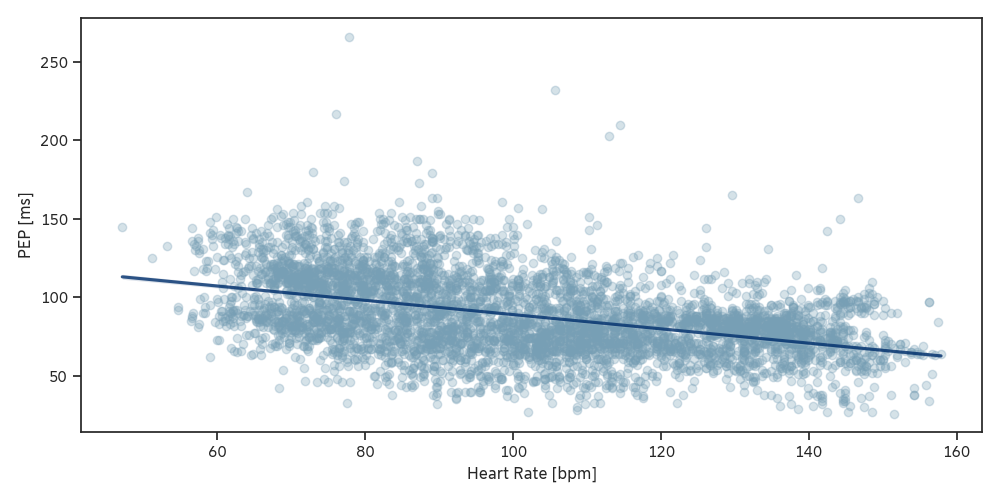

In [33]:
fig, ax = regplot_pep_heart_rate(results_empkins.per_sample, algo_combination)

In [ ]:
#for key, df in results_empkins.per_sample.groupby(algo_levels):
#    fig, ax = plot_error_residual(df, algorithm=key)

In [ ]:
results_empkins.per_sample[("nan_reason", "estimated")].groupby(algo_levels).value_counts().to_frame()

In [ ]:
algo_test = results_empkins.per_sample.xs(("dwt-neurokit", "b-point-reference", "none"))
isna_mask = algo_test[("pep_ms", "estimated")].isna()

algo_test.loc[isna_mask]